以下為正式的最佳化分類運作 Random 選取各群一定比例的數據

In [ ]:
import smote_variants as sv
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import math
from sklearn import metrics
from sklearn.cluster import KMeans  
from sklearn.cluster import AffinityPropagation
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as pl
import random
from sklearn import svm

In [ ]:
# 引入資料
path = "/Users/emily/Desktop/Research/oversampling_python/data/"
folderName = 'glass5-5-fold'#'abalone19-5-fold' # yeast6-5-fold'#'haberman-5-fold' #'abalone19-5-fold' # pima-5-fold yeast-2_vs_8-5-fold

os.chdir(path+ folderName)
dirs = os.listdir(path+ folderName)
train = []
test = []

for i in dirs:
    #print(i.split("-")[-1])
    if("xlsx" in i):
        if("tra" in i):
            train.append(i)

        elif("tst" in i):
            test.append(i)
train = sorted(train)
test = sorted(test)

In [ ]:
# 計算要補多少值
def find_maj(sample_class): # 給 class 資料
    counter = Counter(sample_class);
    maj = list(dict(counter.most_common(1)).keys())
    maj = "".join(maj)
    #print(maj)
    return  maj


def classprocess(output):
    c = Counter(output)
    datagap = []
    maj = find_maj(output)
    maj_num = dict(c)[find_maj(output)]
    for className, number in c.items(): 
        #print(className," ",number)
     #   print(number)
        temp = np.array([className,(maj_num - number)])
        datagap.append(temp)
    return datagap

In [ ]:
data = pd.read_excel(train[0],index_col=0)
data

2021-08-08 05:12:13,209:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


原本 157


2021-08-08 05:12:14,123:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


countfor 62
長度 62
原本 157


2021-08-08 05:12:14,750:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


countfor 62
長度 62
原本 157


2021-08-08 05:12:15,228:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


countfor 62
長度 62
原本 157


2021-08-08 05:12:15,787:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")


countfor 62
長度 62
原本 156
countfor 62
長度 64


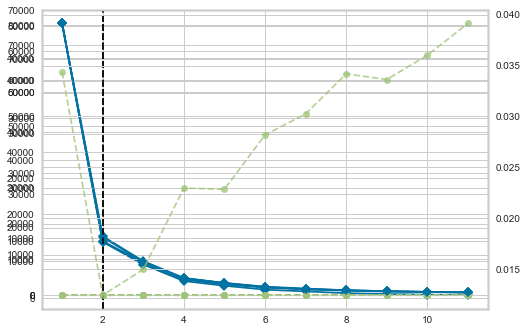

In [124]:
# Cluster 最佳化群數後 各群 random 選資料
# polynom_fit_SMOTE
alloverpolynom = []
overpolynom = []

randompolynom =[]
countfor = 0;

for ii,i in enumerate(train):
    
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    #print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.polynom_fit_SMOTE() # 產生數據
    
    X_polynom,y_polynom = over.sample(finaldata,output)
    #print(Counter(y_polynom)) # smote 後的狀況
    #newDataCount = len(X_polynom) - len(data)  # 新生成的 data 數量

    # 把 X_polynom 跟 y_polynom 和在一起
    X_polynom = pd.DataFrame(X_polynom)
    y_polynom = pd.DataFrame(y_polynom)
    alloverpolynom = pd.concat([X_polynom,y_polynom],axis=1) 
    
    overpolynom.append(alloverpolynom)
    #print(overpolynom[ii])

    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1]); #原本的數據量
       
        countfor = math.floor(int(classCount[i][1])*0.4); # 要產生多少數據  無條件捨去
        
        
        if(countfor>0):
            print("原本",origincount)

            dtemp = pd.DataFrame(overpolynom[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類 # 把最後的類別拿掉
            X_ = dtemp.iloc[originlen:,-1] # 拿掉的分類 雖然都一樣
            X.reset_index(inplace=True, drop=True)
            X_.reset_index(inplace=True, drop=True)
            #print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            
            df = pd.concat([X,X_,klabel],axis=1)
            X = X.astype('float64')    
            # random 挑選各群的資料
        
            ct = 0 
            randomvaluetemp = [] # 放不同切分資料集的值
            
            for ic in range(cluster_count):
                ct+=1
                randomIndex = []
                randomtemp = []
                #temppolynom = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                countforlabel = math.ceil(countfor * labelRatio[ic])    
                
                tempdf.reset_index(drop=True, inplace=True)
                # 不同群的random
                randomIndex.extend([random.randint(0,len(tempdf)-1) for _ in range(countforlabel)]) #該群的index

                # 該群真實的值 index 是位置
                for index in randomIndex:
                    randomtemp.append(tempdf.iloc[index,:-1])

                randomvaluetemp.extend(randomtemp) # 一個切分資料集 所有群的資料
            print("countfor",countfor)
            print("長度",len(randomvaluetemp))
                
            randompolynom.append(randomvaluetemp) # 所有資料集要取的資料

2021-08-08 05:12:17,019:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


原本 157


2021-08-08 05:12:18,284:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


countfor 47
長度 48
原本 157


2021-08-08 05:12:19,089:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


countfor 47
長度 48
原本 157


2021-08-08 05:12:19,750:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


countfor 47
長度 48
原本 157


2021-08-08 05:12:20,280:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


countfor 47
長度 48
原本 156
countfor 46
長度 48


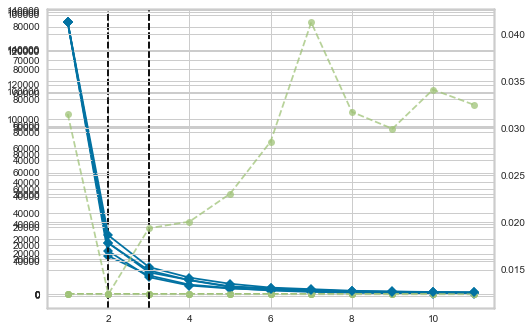

In [125]:
# Cluster 最佳化群數後 各群 random 選資料
# ProWSyn
alloverProWSyn = []
overProWSyn = []

randomProWSyn =[]
countfor = 0;

for ii,i in enumerate(train):
    
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    #print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.ProWSyn() # 產生數據
    
    X_ProWSyn,y_ProWSyn = over.sample(finaldata,output)
    #print(Counter(y_ProWSyn)) # smote 後的狀況
    #newDataCount = len(X_ProWSyn) - len(data)  # 新生成的 data 數量

    # 把 X_ProWSyn 跟 y_ProWSyn 和在一起
    X_ProWSyn = pd.DataFrame(X_ProWSyn)
    y_ProWSyn = pd.DataFrame(y_ProWSyn)
    alloverProWSyn = pd.concat([X_ProWSyn,y_ProWSyn],axis=1) 
    
    overProWSyn.append(alloverProWSyn)
    #print(overProWSyn[ii])

    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1]); #原本的數據量
       
        countfor = math.floor(int(classCount[i][1])*0.3); # 要產生多少數據  無條件捨去
        
        
        if(countfor>0):
            print("原本",origincount)
            dtemp = pd.DataFrame(overProWSyn[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類 # 把最後的類別拿掉
            X_ = dtemp.iloc[originlen:,-1] # 拿掉的分類 雖然都一樣
            X.reset_index(inplace=True, drop=True)
            X_.reset_index(inplace=True, drop=True)
            #print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            
            df = pd.concat([X,X_,klabel],axis=1)
            X = X.astype('float64')    
            # random 挑選各群的資料
        
            ct = 0 
            randomvaluetemp = [] # 放不同切分資料集的值
            
            for ic in range(cluster_count):
                ct+=1
                randomIndex = []
                randomtemp = []
                #tempProWSyn = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                countforlabel = math.ceil(countfor * labelRatio[ic])    
                
                tempdf.reset_index(drop=True, inplace=True)
                # 不同群的random
                randomIndex.extend([random.randint(0,len(tempdf)-1) for _ in range(countforlabel)]) #該群的index

                # 該群真實的值 index 是位置
                for index in randomIndex:
                    randomtemp.append(tempdf.iloc[index,:-1])

                randomvaluetemp.extend(randomtemp) # 一個切分資料集 所有群的資料
            print("countfor",countfor)
            print("長度",len(randomvaluetemp))
                
            randomProWSyn.append(randomvaluetemp) # 所有資料集要取的資料

In [ ]:
# polynom  ProWSyn
allRandomHalf = []

temp = []
for i in range(len(randomProWSyn)):
    temp = randompolynom[i] + randomProWSyn[i] # list 合併
    temp = np.array(temp)
    allRandomHalf.append(temp)

for j in range(len(allRandomHalf)):
    allRandomHalf[j] = pd.DataFrame(allRandomHalf[j],columns=data.columns)



In [ ]:
len(allRandomHalf[0])

2021-08-08 05:12:21,191:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2021-08-08 05:12:21,192:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from '/Users/emily/Desktop/Research/oversampling_python/venv/lib/python3.7/site-packages/numpy/random/__init__.py'>}")
2021-08-08 05:12:21,203:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:21,212:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:21,221:INFO:SMOTE_IPF: Removing 0 elements


原本 157


2021-08-08 05:12:21,896:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2021-08-08 05:12:21,897:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from '/Users/emily/Desktop/Research/oversampling_python/venv/lib/python3.7/site-packages/numpy/random/__init__.py'>}")
2021-08-08 05:12:21,911:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:21,923:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:21,933:INFO:SMOTE_IPF: Removing 0 elements


countfor 47
長度 49
原本 157


2021-08-08 05:12:22,610:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2021-08-08 05:12:22,611:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from '/Users/emily/Desktop/Research/oversampling_python/venv/lib/python3.7/site-packages/numpy/random/__init__.py'>}")
2021-08-08 05:12:22,630:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:22,645:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:22,662:INFO:SMOTE_IPF: Removing 0 elements


countfor 47
長度 48
原本 157


2021-08-08 05:12:23,412:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2021-08-08 05:12:23,412:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from '/Users/emily/Desktop/Research/oversampling_python/venv/lib/python3.7/site-packages/numpy/random/__init__.py'>}")
2021-08-08 05:12:23,422:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:23,430:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:23,438:INFO:SMOTE_IPF: Removing 0 elements


countfor 47
長度 48
原本 157


2021-08-08 05:12:24,091:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2021-08-08 05:12:24,092:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from '/Users/emily/Desktop/Research/oversampling_python/venv/lib/python3.7/site-packages/numpy/random/__init__.py'>}")
2021-08-08 05:12:24,104:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:24,114:INFO:SMOTE_IPF: Removing 0 elements
2021-08-08 05:12:24,124:INFO:SMOTE_IPF: Removing 0 elements


countfor 47
長度 48
原本 156
countfor 46
長度 47


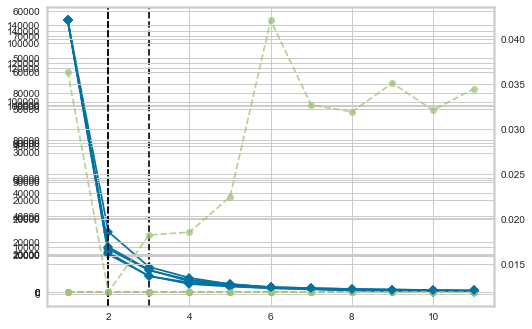

In [126]:
# Cluster 最佳化群數後 各群 random 選資料
# SMOTEIPF
alloverSMOTEIPF = []
overSMOTEIPF = []

randomSMOTEIPF =[]
countfor = 0;

for ii,i in enumerate(train):
    
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    #print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.SMOTE_IPF() # 產生數據
    
    X_SMOTEIPF,y_SMOTEIPF = over.sample(finaldata,output)
    #print(Counter(y_SMOTEIPF)) # smote 後的狀況
    #newDataCount = len(X_SMOTEIPF) - len(data)  # 新生成的 data 數量

    # 把 X_SMOTEIPF 跟 y_SMOTEIPF 和在一起
    X_SMOTEIPF = pd.DataFrame(X_SMOTEIPF)
    y_SMOTEIPF = pd.DataFrame(y_SMOTEIPF)
    alloverSMOTEIPF = pd.concat([X_SMOTEIPF,y_SMOTEIPF],axis=1) 
    
    overSMOTEIPF.append(alloverSMOTEIPF)
    #print(overSMOTEIPF[ii])

    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1]); #原本的數據量
       
        countfor = math.floor(int(classCount[i][1])*0.3); # 要產生多少數據  無條件捨去

        
        
        if(countfor>0):
            print("原本",origincount)
            dtemp = pd.DataFrame(overSMOTEIPF[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類 # 把最後的類別拿掉
            X_ = dtemp.iloc[originlen:,-1] # 拿掉的分類 雖然都一樣
            X.reset_index(inplace=True, drop=True)
            X_.reset_index(inplace=True, drop=True)
            #print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            
            df = pd.concat([X,X_,klabel],axis=1)
            X = X.astype('float64')    
            # random 挑選各群的資料
        
            ct = 0 
            randomvaluetemp = [] # 放不同切分資料集的值
            
            for ic in range(cluster_count):
                ct+=1
                randomIndex = []
                randomtemp = []
                #tempSMOTEIPF = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                countforlabel = math.ceil(countfor * labelRatio[ic])    
                
                tempdf.reset_index(drop=True, inplace=True)
                # 不同群的random
                randomIndex.extend([random.randint(0,len(tempdf)-1) for _ in range(countforlabel)]) #該群的index

                # 該群真實的值 index 是位置
                for index in randomIndex:
                    randomtemp.append(tempdf.iloc[index,:-1])

                randomvaluetemp.extend(randomtemp) # 一個切分資料集 所有群的資料
            print("countfor",countfor)
            print("長度",len(randomvaluetemp))
                
            randomSMOTEIPF.append(randomvaluetemp) # 所有資料集要取的資料

In [ ]:
# polynom SMOTE_IPF
allRandomHalf = []

temp = []
for i in range(len(randompolynom)):
    temp = randompolynom[i] + randomSMOTEIPF[i] # list 合併
    temp = np.array(temp)
    allRandomHalf.append(temp)

for j in range(len(allRandomHalf)):
    allRandomHalf[j] = pd.DataFrame(allRandomHalf[j],columns=data.columns)



In [ ]:
# ProWSyn SMOTE_IPF
allRandomHalf = []

temp = []
for i in range(len(randomProWSyn)):
    temp = randomSMOTEIPF[i] + randomProWSyn[i] # list 合併
    temp = np.array(temp)
    allRandomHalf.append(temp)

for j in range(len(allRandomHalf)):
    allRandomHalf[j] = pd.DataFrame(allRandomHalf[j],columns=data.columns)




In [127]:
# polynom ProWSyn SMOTE_IPF 三個合併
allRandomHalf = []

temp = []
for i in range(len(randomProWSyn)):
    temp = randomSMOTEIPF[i] + randomProWSyn[i] # list 合併
    temp = temp + randompolynom[i]
    temp = np.array(temp)
    allRandomHalf.append(temp)

for j in range(len(allRandomHalf)):
    allRandomHalf[j] = pd.DataFrame(allRandomHalf[j],columns=data.columns)




In [128]:
# # 跟原始資料合併
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
mergeRandom = []
accuracies =[]
for index,element in enumerate(train):
    data = pd.read_excel(element,index_col =0);
    lastColumn = data.columns[-1]

    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    l = data.shape[1]-1
    le = preprocessing.LabelEncoder()
    data.iloc[:,l] = le.fit_transform(data.iloc[:,l])
    data.iloc[:,0] = le.fit_transform(data.iloc[:,0])
  
    mergeRandom = pd.concat([data,allRandomHalf[index]],axis=0)
    
    finaldata = mergeRandom.iloc[:,:l]
    output = mergeRandom.iloc[:,l]
    print(Counter(output))
    
    clf=svm.SVC(kernel='rbf',C=1,gamma='auto')
    clf = clf.fit(finaldata, output)


    test_file = pd.read_excel(test[index],index_col=0) #不然會有多出來的 unnamed column
    test_data = pd.DataFrame(test_file);
    #test_data.Class= test_data.Class.str.replace("\n", "").str.strip()   

    test_X = test_data.iloc[:,:(test_data.shape[1])-1] 
   
    test_X.iloc[:,0] = le.fit_transform(test_X.iloc[:,0])

    test_y_predicted = clf.predict(test_X)

    test_y = test_data.iloc[:,test_data.shape[1]-1] 

    test_y = le.fit_transform(test_y)
    test_y_predicted = le.fit_transform(test_y_predicted)

    accuracy = roc_auc_score(test_y, test_y_predicted)
    accuracies.append(accuracy)
    
mean = statistics.mean(accuracies)
print(mean)


Counter({1.0: 166, 0.0: 164})
Counter({1.0: 165, 0.0: 164})
Counter({1.0: 165, 0.0: 164})
Counter({1.0: 165, 0.0: 164})
Counter({1.0: 167, 0.0: 164})
0.4902439024390244
